# Initial conditions of test case

In this notebook we summarise the previous results and refocus on setting up the initial conditions.

See the details of the case below the imports and core function definitions in the cell below:

In [53]:

from scipy.spatial import Delaunay
#import polyscope as ps


# ddg imports
import os, sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from hyperct import *
from ddgclib._sphere import *


def distance(a, b):
    return np.linalg.norm(a - b)

def circumcenter(vertices):
    A, B, C = vertices
    a = distance(B, C)
    b = distance(C, A)
    c = distance(A, B)

    if a == 0 or b == 0 or c == 0:
        raise ValueError("Invalid triangle: degenerate or duplicate vertices")

    # Calculate the circumradius
    s = (a + b + c) / 2
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))
    circumradius = (a * b * c) / (4 * area)

    # Calculate the normalized barycentric coordinates
    alpha = (a * a * (b * b + c * c - a * a)) / (a * a + b * b + c * c)
    beta = (b * b * (c * c + a * a - b * b)) / (a * a + b * b + c * c)
    gamma = (c * c * (a * a + b * b - c * c)) / (a * a + b * b + c * c)

    circumcenter = (alpha * A + beta * B + gamma * C) / (alpha + beta + gamma)

    return circumcenter

# Example usage
#triangle_vertices = np.array([[1, 2, 0], [4, 0, 1], [0, 0, 5]], dtype=np.float64)
#print("Circumcenter:", circumcenter(triangle_vertices))


# Write a function that builds a dual cache called HC.Vd,
# each member of the `Vd` set should be connect only to primal
# vertices in HC.V

#dist = np.linalg.norm(v.x_a - v2.x_a)
#            if dist < cdist:
        
def compute_vd(HC, cdist =1e-10):
    """
    Computes the dual vertices of a primal vertex cache HC.V on
    each dim - 1 simplex.
    
    Currently only dim = 2 is supported
    
    cdist: float, tolerance for where a unique dual vertex can exist
    
    """
    # Construct dual cache
    HC.Vd = VertexCacheField() 
    
    # Construct dual neighbour sets
    for v in HC.V:
        v.vd = set()
            
    #hcv = copy.copy(HC.V)        
    for v1 in HC.V:
        for v2 in v1.nn:
            # Find all v2.nn also connected to v1:
            v1nn_u_v2nn = v1.nn.intersection(v2.nn)
            for v3 in v1nn_u_v2nn:
                # TODO: Re-implement cache:
                verts = np.zeros([3, 2])
                verts[0] = v1.x_a
                verts[1] = v2.x_a
                verts[2] = v3.x_a
                # Compute the circumcentre:
                cd = circumcenter(verts)
                # Note instead of below, could round off cd in general to say nearest 1e-12
                # Check for uniqueness first (new, expensive, could 
                # be improved by checking duals of neighbours only?):
                for vd_i in HC.Vd:
                    dist = np.linalg.norm(vd_i.x_a - cd)
                    if dist < cdist:
                        cd = vd_i.x_a
                        
                vd = HC.Vd[tuple(cd)]
                # Connect to all primal vertices
                for v in [v1, v2, v3]:
                    v.vd.add(vd)
                    vd.nn.add(v)
                    
    return HC  # self

# Test case traingulation
def incom_Poi(domain, refinements=2):
    """
    Compute the triangulate of a 2D incompressible Poiseuile flow
    """
    HC = Complex(2, domain)
    HC.triangulate()
    for i in range(refinements):
        HC.refine_all()

    points = []
    for v in HC.V:
        points.append(v.x_a)
    points = np.array(points)
    tri = Delaunay(points)
    return points

# Find the Delaunay dual
def triang_dual(points, plot_delaunay=False):
    """
    Compute the Delaunay triangulation plus the dual points. Put into hyperct complex object.
    
    """
    tri = Delaunay(points)
    if plot_delaunay:  # Plot Delaunay complex
        import matplotlib.pyplot as plt
        plt.triplot(points[:,0], points[:,1], tri.simplices)
        plt.plot(points[:,0], points[:,1], 'o')
        plt.show()

    # Put Delaunay back into hyperct Complex object:
    HC = Complex(2)
    for s in tri.simplices:
        for v1i in s:
            for v2i in s:
                if v1i is v2i:
                    continue
                else:
                    v1 = tuple(points[v1i])
                    v2 = tuple(points[v2i])
                    HC.V[v1].connect(HC.V[v2])

    return HC
    
    
# Plot duals
def plot_dual_mesh_2D(HC):
    """
    Plot the dual mesh and show edge connectivity. Blue is the primary mesh. Orange is the dual mesh.
    """
    import matplotlib.pyplot as plt
    
    # Find the dual points
    dual_points = []
    for vd in HC.Vd:
        #print('-')
        #print(vd.x_a)
        dual_points.append(vd.x_a)
        #for vdn in vd.v
    dual_points = np.array(dual_points)
    
    for v in HC.V:
        # "Connect duals":
        for v2 in v.nn:
            v1vdv2vd = v.vd.intersection(v2.vd)  # Cardinality always 1 or 2?
            if len(v1vdv2vd) == 1:
                continue
            v1vdv2vd = list(v1vdv2vd)
            x = [v1vdv2vd[0].x[0], v1vdv2vd[1].x[0]]
            y = [v1vdv2vd[0].x[1], v1vdv2vd[1].x[1]]
            plt.plot(x, y, color='orange')

        for vd in v.vd:
            x = [v.x[0], vd.x[0]]
            y = [v.x[1], vd.x[1]]
            plt.plot(x, y, '--', color='tab:green')
    plt.triplot(points[:,0], points[:,1], tri.simplices, color='tab:blue')
    plt.plot(points[:,0], points[:,1],  'o', color='tab:blue')
    plt.plot(dual_points[:,0], dual_points[:,1], 'o', color='tab:orange')

    plt.show()

# Area computations
def d_area(vp1):
    """
    Compute the dual area of a vertex object vp1, which is the sum of the areas
    of the local dual triangles formed between vp1, its neighbouring vertices, 
    and their shared dual vertices.

    Parameters:
    -----------
    vp1 : object
        A vertex object containing the following attributes:
        - vp1.nn: a list of neighboring vertex objects
        - vp1.vd: a set of dual vertex objects
        - vp1.x_a: a numpy array representing the position of vp1

    Returns:
    --------
    darea : float
        The total dual area of the vertex object vp1
    """

    darea = 0  # Initialize total dual area to zero
    for vp2 in vp1.nn:  # Iterate over neighboring vertex objects
        # Find the shared dual vertices between vp1 and vp2
        vdnn = vp1.vd.intersection(vp2.vd)
        # Compute the midpoint between vp1 and vp2
        mp = (vp1.x_a + vp2.x_a) / 2
        # Compute the height of the dual triangle between vp1, vp2, and a dual vertex
        h = np.linalg.norm(mp - vp1.x_a)
        for vdi in vdnn:  # Iterate over shared dual vertices
            # Compute the base of the dual triangle between vp1, vp2, and vdi
            b = np.linalg.norm(vdi.x_a - mp)
            # Add the area of the dual triangle to the total dual area
            darea += 0.5 * b * h

    return darea


# Incompressible Poiseuille channel fluid flow

For this test case, we will closely follow the FENICS tutorial https://fenicsproject.org/pub/tutorial/html/._ftut1009.html in order to validate our method.


The incompressible Navier-Stokes equations are:
$$
\begin{aligned}
\rho\left(\frac{\partial u}{\partial t}+u \cdot \nabla u\right) & =\nabla \cdot \sigma(u, p)+f \\
\nabla \cdot u & =0 .
\end{aligned}
$$

for a Newtonian fluid we have 
$$
\sigma(u, p)=2 \mu \epsilon(u)-p I
$$
where $\epsilon(u)$ is the strain-rate tensor
$$
\epsilon(u)=\frac{1}{2}\left(\nabla u+(\nabla u)^T\right)
$$

In standard fluid-kinetics notation: 

$$
\Delta p=\frac{8 \mu L Q}{\pi R^4}=\frac{8 \pi \mu L Q}{A^2}
$$

where:
- $\Delta p$ is the pressure difference between the two ends,
- $L$ is the length of pipe,
- $\mu$ is the dynamic viscosity,
- $Q$ is the volumetric flow rate,
- $R$ is the pipe radius,
- $A$ is the cross sectional area of pipe.

In [54]:
import numpy as np
mu = 8.90 * 1e-4  # Pa·s
L = 1  # m
Q = 1  # m3 / s
R = 1  # m
A = 1  # m2  # = 2 pi * R**2 # for pipe
# Pressure drop for pipe
dP = (8 * np.pi * mu * L * Q) / (A**2)

### Plane Poiseuille flow
Plane Poiseuille flow is flow created between two infinitely long parallel plates, separated by a distance $h$ with a constant pressure gradient $G=-\frac{\mathrm{d} p}{\mathrm{dx}}$ is applied in the direction of flow. The flow is essentially unidirectional because of infinite length. The Navier-Stokes equations reduce to
$$
\frac{\mathrm{d}^2 u}{\mathrm{~d} y^2}=-\frac{G}{\mu}
$$
with no-slip condition on both walls
$$
u(0)=0, \quad u(h)=0
$$
Therefore, the velocity distribution and the volume flow rate per unit length are
$$
u(y)=\frac{G}{2 \mu} y(h-y), \quad Q=\frac{G h^3}{12 \mu}
$$

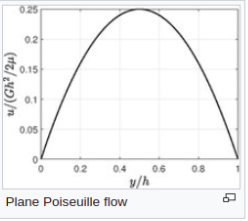


In [134]:
# Physical parameters
h = R  # m, plate seperation
Q = 1  # m/s, specify volumetric flowrate
G = (Q * 12 * mu) / (h**3)
rho = 1000  # kg / m3
#G = dP/ L

# Initial condition:
def u_ic(x):
    y = x[1]
    return (G / 2 * mu) * y * (h - y)

# Boundary conditions:
def u_bc(x):
    y = x[1]
    if y == 0:
        return 0.0
    elif y == h:
        return 0.0

# Triangulate case


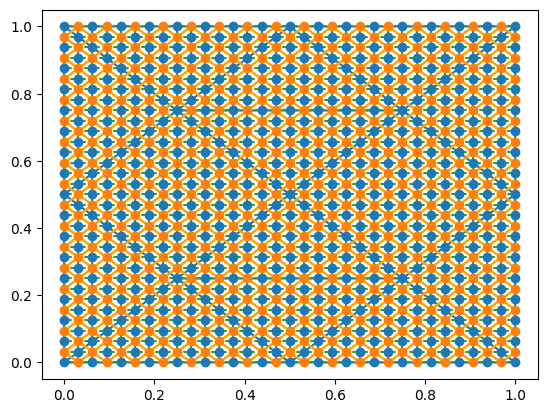

In [99]:
# Solid boundaries of plate
x_lb = 0
x_ub = R  # For simplicity
y_lb = 0
y_ub = R  # Actual parallel plate dimension
domain = [(x_lb, x_ub), (y_lb, y_ub)]
points = incom_Poi(domain, refinements=4)
HC = triang_dual(points)
#HC.vertex_face_mesh(field_conversions=True)              
HC = compute_vd(HC)            
# Optionally plot
plot_dual_mesh_2D(HC)

# For each vertex compute its local dual area:
import numpy as np

Areas = []
for vp1 in HC.V:
    area = 0 
    area += d_area(vp1)
    Areas.append(area)


In [100]:
np.sum(Areas)  # Validated this for 1x1 and 2x2 grids

1.0000000000000002906

## Set the initial mass of the fluid particles

Each particle should have mass $m = \rho V$ where $V = Area \times 1$ for simplicity.

In [105]:
def mass_IC(HC):
    # Set mass of each fluid particle:
    for v in HC.V:
        # Compute the dual area around a particle:
        area = d_area(v)
        V = area * 1  # m3, can be modified later
        # Set mass in kg
        v.m = rho * V
        
# Test:
mass_IC(HC)
for v in HC.V:
    print(v.m)

0.97656249999999999995
1.953125
0.48828125000000005416
0.97656249999999999995
1.9531249999999999999
0.97656249999999999995
0.48828124999999999997
0.97656249999999999995
1.9531249999999999999
0.97656249999999999995
0.97656249999999999995
1.9531249999999999999
1.9531249999999999999
0.97656249999999999995
0.97656249999999999995
1.9531249999999999999
1.9531249999999999999
0.97656249999999999995
1.9531249999999999999
0.97656249999999999995
1.9531249999999999999
0.97656249999999999995
1.9531250000000017347
0.97656249999999999995
1.9531249999999999999
0.97656249999999999995
0.97656249999999999995
1.9531249999999999999
1.9531250000000017347
0.97656249999999999995
1.9531249999999999999
0.97656249999999999995
1.9531249999999999999
0.97656249999999999995
1.9531249999999999999
0.97656249999999999995
1.953125
0.48828125000000010837
0.97656250000000021684
1.9531250000000001084
0.97656249999999999995
1.9531250000000001084
0.97656250000000021684
1.9531250000000001084
0.97656249999999999995
1.953125000

## Set initial velocity field

In [135]:
def v_IC(HC):
    # Assign velocity field to all points:
    for v in HC.V:
        v.u = np.array([u_ic(v.x_a), 0])

# Test
v_IC(HC)
for v in HC.V:
    print(v.u)

[-2.970375e-05  0.000000e+00]
[2.22778125e-05 0.00000000e+00]
[0. 0.]
[0. 0.]
[-0.03384  0.     ]
[-0.03163449  0.        ]
[-0.03611976  0.        ]
[-0.03611976  0.        ]
[-0.00015594  0.        ]
[-0.00035644  0.        ]
[-0.00098022  0.        ]
[-0.0006312  0.       ]
[-0.0014035  0.       ]
[-0.00190104  0.        ]
[-0.00311889  0.        ]
[-0.00247284  0.        ]
[-0.02950325  0.        ]
[-0.02744626  0.        ]
[-0.02546354  0.        ]
[-0.02355507  0.        ]
[-0.02172087  0.        ]
[-0.01996092  0.        ]
[-0.01827523  0.        ]
[-0.0166638  0.       ]
[-0.00383921  0.        ]
[-0.00463378  0.        ]
[-0.00644571  0.        ]
[-0.00550262  0.        ]
[-0.01512663  0.        ]
[-0.01366372  0.        ]
[-0.01227507  0.        ]
[-0.01096068  0.        ]
[-0.00746307  0.        ]
[-0.00855468  0.        ]
[-0.00972055  0.        ]
[0. 0.]
[2.22778125e-05 0.00000000e+00]
[0. 0.]
[-2.970375e-05  0.000000e+00]
[2.22778125e-05 0.00000000e+00]
[0. 0.]
[2.2277812

# Old:

---
---
---


# Velocity Fields

In [25]:
# Assign velocity field to all points:
for v in HC.V:
    v.u = np.array([u(v.x_a), 0])

In [27]:
points= []
for vd in HC.Vd:
    print('-')
    print(f'vd.x = {vd.x}')
    points.append(vd.x)
    for vn in vd.nn:
        print(f'vn.x = {vn.x}')
points = np.array(vd.x)
#plt.figure()
plt.scatter(points)

-
vd.x = (0.5, 1.1102230246251563e-16)
vn.x = (1, 0)
vn.x = (0.5, 0.5)
vn.x = (0, 0)
-
vd.x = (1.1102230246251563e-16, 0.5)
vn.x = (0, 1)
vn.x = (0.5, 0.5)
vn.x = (0, 0)
-
vd.x = (0.9999999999999998, 0.5)
vn.x = (1, 0)
vn.x = (0.5, 0.5)
vn.x = (1, 1)
-
vd.x = (0.5, 0.9999999999999998)
vn.x = (0, 1)
vn.x = (0.5, 0.5)
vn.x = (1, 1)


TypeError: scatter() missing 1 required positional argument: 'y'

# Time integrator

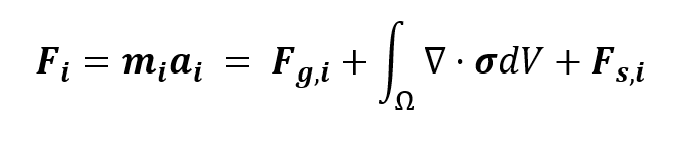

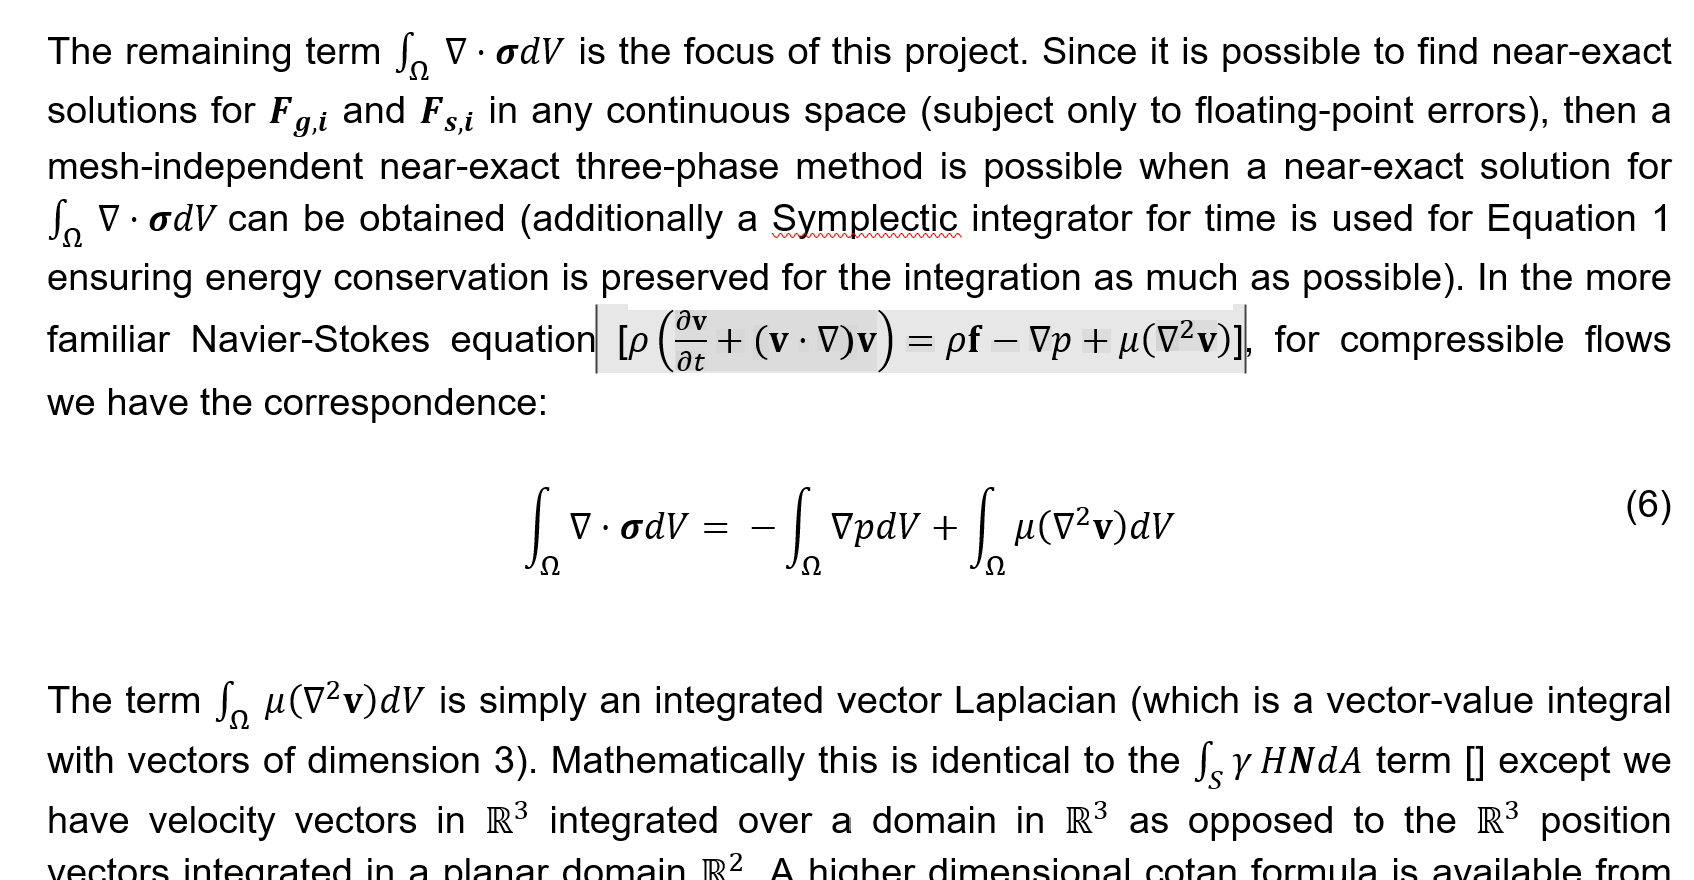



In [ ]:

import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2

def laplacian(Z, dx):
    Z_left = np.roll(Z, shift=-1, axis=1)
    Z_right = np.roll(Z, shift=1, axis=1)
    Z_up = np.roll(Z, shift=-1, axis=0)
    Z_down = np.roll(Z, shift=1, axis=0)
    return (Z_left + Z_right + Z_up + Z_down - 4 * Z) / dx**2

def simulate_flow(N, dt, T_end, nu, forcing):
    dx = 1 / N
    X, Y = np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))
    
    omega = np.zeros((N, N))
    psi = np.zeros((N, N))
    
    T = 0
    while T < T_end:
        omega_hat = fft2(omega)
        kx, ky = np.meshgrid(np.arange(N), np.arange(N))
        laplacian_k = 2 * (np.cos(2 * np.pi * kx / N) + np.cos(2 * np.pi * ky / N) - 2)
        laplacian_k[0, 0] = 1  # Avoid division by zero
        psi_hat = -omega_hat / laplacian_k
        psi = np.real(ifft2(psi_hat))
        
        u = np.roll(psi, shift=1, axis=0) - np.roll(psi, shift=-1, axis=0)
        v = -np.roll(psi, shift=1, axis=1) + np.roll(psi, shift=-1, axis=1)
        
        omega_t = -u * laplacian(omega, dx) - v * laplacian(omega.T, dx).T + nu * laplacian(omega, dx) + forcing(X, Y, T)
        omega += dt * omega_t
        T += dt
        
    return X, Y, psi

def forcing(X, Y, T):
    F = 10 * np.sin(np.pi * X) * np.sin(np.pi * Y) * np.exp(-T / 8)
    return F

N = 128
dt = 0.001
T_end = 10
nu = 0.01

if 0:
    X, Y, psi = simulate_flow(N, dt, T_end, nu, forcing)
    u = np.roll(psi, shift=1, axis=0) - np.roll(psi, shift=-1, axis=0)
    v = -np.roll(psi, shift=1, axis=1) + np.roll(psi, shift=-1, axis=1)

    plt.figure(figsize=(8, 8))
    plt.streamplot(X, Y, u, v, density=2)
    plt.show()


In [ ]:
domain = p[]

The exact solution is derived by assuming $u=\left(u_x(x, y, z), 0,0\right)$, with the $x$ axis pointing along the channel. Since $\nabla \cdot u=0$, $u$ cannot depend on $x$. The physics of channel flow is also two-dimensional so we can omit the $z$ coordinate (more precisely: $\partial / \partial z=0$ ). Inserting $u=\left(u_x, 0,0\right)$ in the (scaled) governing equations gives $u_x^{\prime \prime}(y)=\partial p / \partial x$. Differentiating this equation with respect to $x$ shows that $\partial^2 p / \partial^2 x=0$ so $\partial p / \partial x$ is a constant, here called $-\beta$. This is the driving force of the flow and can be specified as a known parameter in the problem. Integrating $u_x^{\prime \prime}(y)=-\beta$ over the width of the channel, $[0,1]$, and requiring $u=(0,0,0)$ at the channel walls, results in $u_x=\frac{1}{2} \beta y(1-y)$. The characteristic inlet velocity $U$ can be taken as the maximum inflow at $y=1 / 2$, implying $\beta=8$. The length of the channel, $L / H$ in the scaled model, has no impact on the result, so for simplicity we just compute on the unit square. Mathematically, the pressure must be prescribed at a point, but since $p$ does not depend on $y$, we can set $p$ to a known value, e.g. zero, along the outlet boundary $x=1$. The result is $p(x)=8(1-x)$ and $u_x=4 y(1-y)$.

The boundary conditions can be set as $p=8$ at $x=0, p=0$ at $x=1$ and $u=(0,0,0)$ on the walls $y=0,1$. This defines the pressure drop and should result in unit maximum velocity at the inlet and outlet and a parabolic velocity profile without further specifications. Note that it is only meaningful to solve the Navier-Stokes equations in 2D or 3D geometries, although the underlying mathematical problem collapses to two 1D problems, one for $u_x(y)$ and one for $p(x)$.

In [90]:
#Analytical
U_char = 0.  # at y= 1/2
def u_x_analytical(y):
    return 4 * y * (1 - y)

In [127]:
def plot_field(p, u, vfac=1e6):
    """
    Plot the velocity fields using points `p` and
    associated velocities `u`.
    
    vfac adjusts the arrow length to account for very low velocities in the field
    """
    import numpy as np
    import matplotlib.pyplot as plt

    positions = p
    velocities = u

    # Separate the positions and velocities into x, y, u, and v arrays
    x, y = positions[:, 0], positions[:, 1]
    u, v = velocities[:, 0]*vfac, velocities[:, 1]

    # Calculate the magnitude of the velocity vectors
    magnitude = np.sqrt(u**2 + v**2) #* 1e7

    plt.figure(figsize=(8, 8))
    plt.quiver(x, y, u, v, magnitude, cmap='viridis', scale=10)
    plt.colorbar(label='Magnitude of Velocity')
    plt.title('Quiver Plot from Position Points and Velocity Vectors')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()


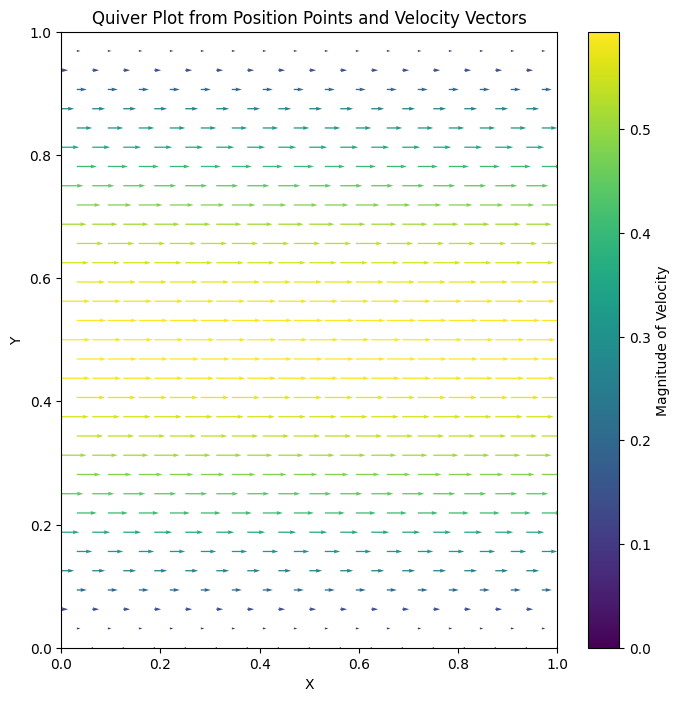

In [130]:
plot_field(p, u, vfac=5e5)

In [117]:
help(plt.quiver)

Help on function quiver in module matplotlib.pyplot:

quiver(*args, data=None, **kwargs)
    Plot a 2D field of arrows.
    
    Call signature::
    
      quiver([X, Y], U, V, [C], **kw)
    
    *X*, *Y* define the arrow locations, *U*, *V* define the arrow directions, and
    *C* optionally sets the color.
    
    Each arrow is internally represented by a filled polygon with a default edge
    linewidth of 0. As a result, an arrow is rather a filled area, not a line with
    a head, and `.PolyCollection` properties like *linewidth*, *linestyle*,
    *facecolor*, etc. act accordingly.
    
    **Arrow size**
    
    The default settings auto-scales the length of the arrows to a reasonable size.
    To change this behavior see the *scale* and *scale_units* parameters.
    
    **Arrow shape**
    
    The defaults give a slightly swept-back arrow; to make the head a
    triangle, make *headaxislength* the same as *headlength*. To make the
    arrow more pointed, reduce *headwidth* 

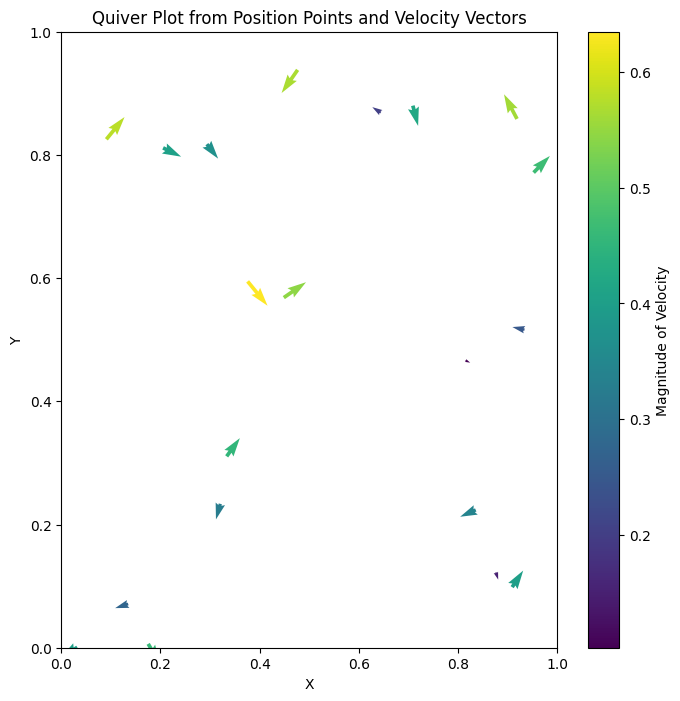

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random position points and corresponding velocity vectors
num_points = 20
positions = np.random.rand(num_points, 2)
velocities = np.random.rand(num_points, 2) - 0.5

# Separate the positions and velocities into x, y, u, and v arrays
x, y = positions[:, 0], positions[:, 1]
u, v = velocities[:, 0], velocities[:, 1]

# Calculate the magnitude of the velocity vectors
magnitude = np.sqrt(u**2 + v**2)

plt.figure(figsize=(8, 8))
plt.quiver(x, y, u, v, magnitude, cmap='viridis', scale=10)
plt.colorbar(label='Magnitude of Velocity')
plt.title('Quiver Plot from Position Points and Velocity Vectors')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()


In [98]:
velocities[:, 0], velocities[:, 1]

(array([-0.261977  ,  0.36652383, -0.2626433 ,  0.23311177,  0.04656657,
         0.22668346, -0.24358354,  0.22221684,  0.10596694,  0.32736272,
        -0.33824647, -0.32268643,  0.09352392, -0.17100272, -0.08814264,
         0.40153605, -0.31390886,  0.2654376 ,  0.36369927,  0.44744369]),
 array([ 0.49619664,  0.44844075, -0.08367637, -0.39621514, -0.14530885,
        -0.29102863,  0.05373958,  0.33340477, -0.40767495,  0.33478423,
        -0.21532243, -0.46647594, -0.04304026,  0.11037806, -0.31362101,
        -0.49121351, -0.1373776 ,  0.36715799, -0.17721023,  0.31072979]))